# Setup

In [1]:
import json
import os
import sys
import pickle
import warnings

sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import ElasticNet, ElasticNetCV, LogisticRegression, LogisticRegressionCV
from sklearn.metrics import classification_report, roc_auc_score, balanced_accuracy_score
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error, median_absolute_error

from utils import read_csv_non_utf, preprocess_data, get_zero_nonzero_datasets, test_thresholds, ratios_to_DI_cats, \
                  get_train_test_split
from model_utils import HurdleModelEstimator
from plotting_utils import plot_ratio_confusion_matrix, plot_model_coefficients

In [2]:
# Loading in general configuration
with open('../config.json', 'r') as f:
    config = json.load(f)

# Getting filepaths
gdrive_fp = config['gdrive_path']
LIFE_fp = config['LIFE_folder']
dataset_fp = config['datasets_path']
benitez_lopez2019 = config['indiv_data_paths']['benitez_lopez2019']

data_path = os.path.join(gdrive_fp, LIFE_fp, dataset_fp, benitez_lopez2019)

In [3]:
# Reading in data as a pandas dataframe
ben_lop2019 = read_csv_non_utf(data_path)

# Fixed effects linear hurdle model

I believe this will more accurately capture generalisation behavior, since we will not be able to make use of the random effects in the original mixed effects models--new species and countries will represent unseen levels on those categorical variables. See [this stackoverflow post](https://stackoverflow.com/questions/29259750/prediction-with-lme4-on-new-levels) for an explanation of `lme4`'s behavior with new levels.

Also, let's use all variables provided and either do our own feature selection or just depend on model regularization to do feature selection for us.

In [25]:
# Modeling parameters
save_model = False
from_save = False
model_save_folder = '../model_saves/hurdle_models'
model_save_fp = 'TEST'

train_size = 0.7

extirp_pos = False
verbose = True

cv = 5 # either int or None... if None, we'll just skip cross-validation
logistic_penalty = 'l1'

#  columns to use for each model 
#   - if None, will use defaults (i.e., Ana's vars)
#   - if an empty list, will not use any vars (really only for indicator cols)
indicator_columns = ['Diet']
nonzero_columns = ['BM', 'DistKm', 'PopDens', 'Stunting', 'TravTime', 'LivestockBio', 'Literacy']
zero_columns = nonzero_columns

polynomial_features = 0

#  hyperparameters for grid search
l1_ratio = [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]
Cs = 20

# Putting all relevant params into a dictionary for saving purposes
param_dict = {'model_save_fp' : model_save_fp,
              'extirp_pos' : extirp_pos,
              'logistic_penalty' : logistic_penalty,
              'indicator_columns' : indicator_columns,
              'nonzero_columns' : nonzero_columns,
              'zero_columns' : zero_columns,
              'l1_ratio' : l1_ratio,
              'Cs' : Cs,
              'polynomial_features' : polynomial_features}

In [26]:
# Getting the shared basic train/test split
idxs = get_train_test_split(len(ben_lop2019), train_size = train_size)

# Pre-processing data
pp_data = preprocess_data(ben_lop2019, include_indicators = True, standardize = True, log_trans_cont = False,
                          polynomial_features = polynomial_features, train_test_idxs = idxs)

#  splitting the actual dataset into train/test sets
train_data, test_data = pp_data.loc[idxs['train']], pp_data.loc[idxs['test']]

# Defining sub-models for hurdle model or read in saved model
if not from_save:
    data_args = {'indicator_columns' : indicator_columns,
                 'nonzero_columns' : nonzero_columns,
                 'zero_columns' : zero_columns}
    
    if cv is not None:
        print('Using cross-validation')
        nonzero_model = ElasticNetCV(cv = cv, l1_ratio = l1_ratio, max_iter = 5000)
        zero_model = LogisticRegressionCV(cv = cv, Cs = Cs, penalty = logistic_penalty, solver = 'saga', max_iter = 500)
    else:
        print('Using single models')
        nonzero_model = ElasticNet(alpha = 0.003, l1_ratio = 0.1, max_iter = 5000)
        zero_model = LogisticRegression(C = 0.616, penalty = 'l1', solver = 'saga', max_iter = 500)
    
    hurdle_model = HurdleModelEstimator(zero_model, nonzero_model, extirp_pos = extirp_pos, verbose = verbose,
                                        data_args = data_args)

    # Fitting on the training data
    with warnings.catch_warnings(action = 'ignore'):
        hurdle_model.fit(train_data)

    # Tuning the probability threshold for the classification model
    X_zero, y_zero, _, _ = get_zero_nonzero_datasets(train_data, extirp_pos = False, pred = False, **data_args)
    
    y_pred_zero = hurdle_model.zero_model.predict_proba(X_zero)
    y_pred_zero = y_pred_zero[ : , 1]
    y_true_zero = y_zero
    
    opt_thresh, metrics = test_thresholds(y_pred_zero, y_true_zero)
    print(f'Best threshold was found to be {round(opt_thresh, 3)} with a TSS of {round(np.max(metrics["TSS"]), 3)}')
    
    # Setting the threshold to the optimal in the hurdle model
    hurdle_model.prob_thresh = round(opt_thresh, 3)

    # Optionally saving the model and hyperparameters
    if save_model:
        print('Saving model...')
        with open(os.path.join(model_save_folder, model_save_fp + '.pkl'), 'wb') as f:
            pickle.dump(hurdle_model, f)
            
        with open(os.path.join(model_save_folder, model_save_fp + '.json'), 'w') as f:
            json.dump(param_dict, f, sort_keys = True, indent = 4)
else:
    print(f'Loading saved model from {model_save_fp}')
    with open(os.path.join(model_save_folder, model_save_fp + '.pkl'), 'rb') as f:
        hurdle_model = pickle.load(f)

# Predicting on the test set
pred_ratios = hurdle_model.predict(test_data)
test_ratios = test_data['ratio']

#  back-transforming to recover actual abundance ratios predicted by the hurdle model
pred_ratios[pred_ratios != 0] = np.exp(pred_ratios[pred_ratios != 0])
pred_DI_cats = ratios_to_DI_cats(pred_ratios)
true_DI_cats = ratios_to_DI_cats(test_ratios)

Using cross-validation
Fitting the nonzero model...
Fitting the zero model...
Best threshold was found to be 0.0 with a TSS of 0.0


## Inspecting learned patterns

### Logistic regression

In [169]:
# Seeing the tuned hyperparam value
best_C = round(hurdle_model.zero_model.C_[0], 3)
print('Logistic regression: best L1 regularization strength (C, lower is higher strength)', best_C)

Logistic regression: best L1 regularization strength (C, lower is higher strength) 0.616


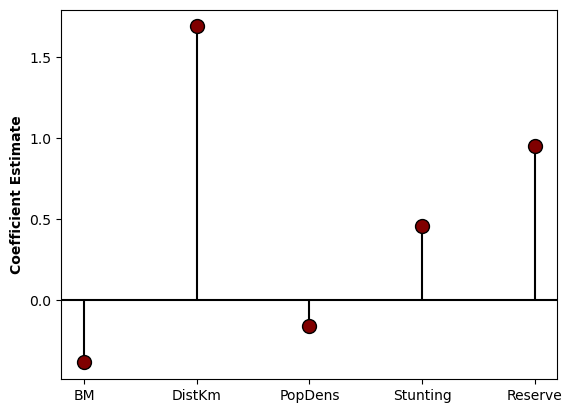

In [170]:
# Taking a look at the coefficient estimates for the spatial predictors
#  - remember: the positive class is locally EXTANT, so a positive coef means there 
#    is a higher chance of avoiding local extirpation
spatial_predictors = hurdle_model.zero_model.feature_names_in_[ : 5]
spatial_coefs = hurdle_model.zero_model.coef_[0, : 5]

fig, ax = plot_model_coefficients(spatial_predictors, spatial_coefs)

In [201]:
# For the indicator-only model: inspecting the weights
feats = hurdle_model.zero_model.feature_names_in_
coefs = hurdle_model.zero_model.coef_[0]

print(f'In total, {(coefs != 0).sum()} features were retained')
print()

for i in range(len(feats)):
    if coefs[i] != 0:
        print(f'{feats[i]}: {round(coefs[i], 3)}')
    if i != len(feats) - 1:
        if (feats[i].split('_')[0] != feats[i + 1].split('_')[0]):
            print()

In total, 95 features were retained

Country_Bolivia: -0.019
Country_Brazil: -0.052
Country_Cameroon: -0.247
Country_Central African Republic: 0.537
Country_French Guiana: -0.534
Country_Honduras: -0.481
Country_Indonesia: 0.549
Country_Madagascar: 0.053
Country_Mexico: -0.23
Country_Nicaragua: 0.201
Country_Paraguay: 0.706
Country_South Africa: -0.489
Country_Tanzania: -0.229
Country_Thailand: -1.762

Species_Alouatta seniculus: -0.625
Species_Ateles geoffroyi: -0.38
Species_Ateles spp: -0.954
Species_Bos gaurus: -0.481
Species_Cebus olivaceus: -0.816
Species_Cercocebus torquatus: -0.646
Species_Cercopithecus erythrotis: 0.217
Species_Cercopithecus nictitans: 0.656
Species_Cercopithecus pogonias: 0.329
Species_Chlorocebus aethiops: -0.088
Species_Colobus satanas: -0.228
Species_Cuniculus paca: -0.044
Species_Elephas maximus: -0.823
Species_Euphractus sexcinctus: -0.135
Species_Gorilla gorilla: -0.363
Species_Mandrillus leucophaeus: -0.633
Species_Mazama americana and Odocoileus virgin

### ElasticNet

In [171]:
# Seeing the tuned hyperparam values
best_alpha = round(hurdle_model.nonzero_model.alpha_, 3)
best_l1_ratio = hurdle_model.nonzero_model.l1_ratio_
print('ElasticNet: best L1/L2 regularization strength (alpha, higher is higher strength)', best_alpha)
print('ElasticNet: best L1 ratio (0 = ridge, 1 = LASSO)', best_l1_ratio)

ElasticNet: best L1/L2 regularization strength (alpha, higher is higher strength) 0.003
ElasticNet: best L1 ratio (0 = ridge, 1 = LASSO) 0.1


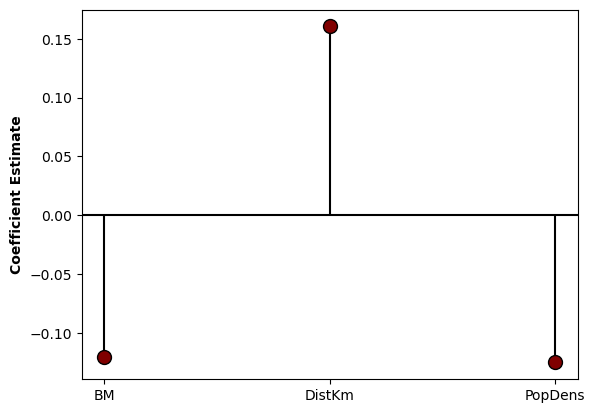

In [172]:
# Taking a look at the coefficient estimates for the spatial predictors
spatial_predictors = hurdle_model.nonzero_model.feature_names_in_[ : 3]
spatial_coefs = hurdle_model.nonzero_model.coef_[ : 3]

fig, ax = plot_model_coefficients(spatial_predictors, spatial_coefs)

In [200]:
# For the indicator-only model: inspecting the weights
feats = hurdle_model.nonzero_model.feature_names_in_
coefs = hurdle_model.nonzero_model.coef_

print(f'In total, {(coefs != 0).sum()} features were retained')
print()

for i in range(len(feats)):
    if coefs[i] != 0:
        print(f'{feats[i]}: {round(coefs[i], 3)}')
    if i != len(feats) - 1:
        if (feats[i].split('_')[0] != feats[i + 1].split('_')[0]):
            print()

In total, 340 features were retained

Country_Belize: 0.314
Country_Bolivia: 0.011
Country_Brazil: 0.146
Country_Burkina Faso: 0.253
Country_Cameroon: -0.237
Country_Central African Republic: 0.291
Country_Colombia: 0.017
Country_Congo: -0.055
Country_Costa Rica: -0.155
Country_Ecuador: 0.152
Country_Equatorial Guinea: 0.047
Country_Ethiopia: -0.044
Country_French Guiana: -0.03
Country_Gabon: -0.024
Country_Ghana: -0.093
Country_Guatemala: 0.193
Country_Guyana: -0.084
Country_India: -0.035
Country_Indonesia: 0.136
Country_Madagascar: -0.089
Country_Mexico: -0.017
Country_Nicaragua: 0.16
Country_Nigeria: -0.111
Country_Panama: -0.452
Country_Tanzania: 0.011
Country_Thailand: -0.442
Country_Uganda: 0.053

Species_Alcelaphus lichtensteinii: 0.082
Species_Alouatta belzebul: -0.095
Species_Alouatta guariba: 0.234
Species_Alouatta palliata: 0.13
Species_Alouatta pigra: 0.044
Species_Alouatta sara: 0.067
Species_Alouatta seniculus: -0.151
Species_Alouatta spp: 0.245
Species_Aotus spp: 0.016
S

## Model evaluation

### Classification performance

This is looking at the model's ability to classify observations into the three defaunation intensity categories.

In [27]:
# Full report of classification relevant metrics based on HARD classifications
print(classification_report(true_DI_cats, pred_DI_cats, target_names = ['low', 'medium', 'high']))

              precision    recall  f1-score   support

         low       0.74      0.34      0.47       560
      medium       0.23      0.82      0.36       207
        high       0.33      0.00      0.01       218

    accuracy                           0.37       985
   macro avg       0.43      0.39      0.28       985
weighted avg       0.54      0.37      0.34       985



In [28]:
# Calculating metrics to match Benitez-Lopez
balanced_acc = balanced_accuracy_score(true_DI_cats, pred_DI_cats)
pseudo_r2 = np.corrcoef(pred_ratios, test_ratios)[0, 1] ** 2

print(f'Balanced accuracy: {round(balanced_acc * 100, 2)}%')
print(f'Pseudo-R^2: {round(pseudo_r2, 3)}')

Balanced accuracy: 38.74%
Pseudo-R^2: 0.002


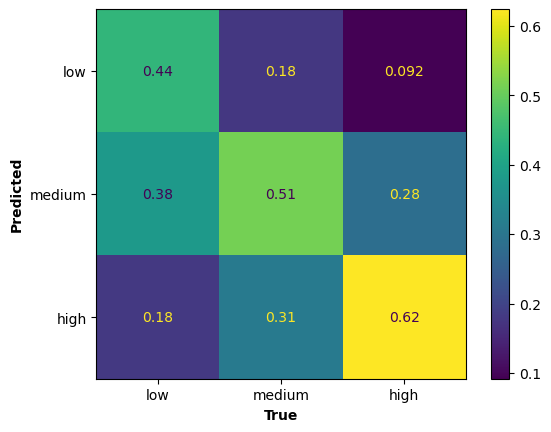

In [175]:
# Confusion matrix
fig, ax = plot_ratio_confusion_matrix(true_DI_cats, pred_DI_cats)

### Regression performance

This looks directly at the model's ability to predict abundance ratios.

In [150]:
def root_median_squared_error(test_ratios, pred_ratios):
    r_med_se = np.sqrt(np.median(np.square(test_ratios - pred_ratios)))

    return r_med_se

In [176]:
# Calculating key regression metrics on all data
mae = mean_absolute_error(test_ratios, pred_ratios)
print(f'Mean absolute error: {round(mae, 3)}')

med_ae = median_absolute_error(test_ratios, pred_ratios)
print(f'Median absolute error: {round(med_ae, 3)}')

rmse = root_mean_squared_error(test_ratios, pred_ratios)
print(f'Root mean squared error: {round(rmse, 3)}')

r_med_se = root_median_squared_error(test_ratios, pred_ratios)
print(f'Root median squared error: {round(r_med_se, 3)}')

Mean absolute error: 0.93
Median absolute error: 0.341
Root mean squared error: 3.477
Root median squared error: 0.341


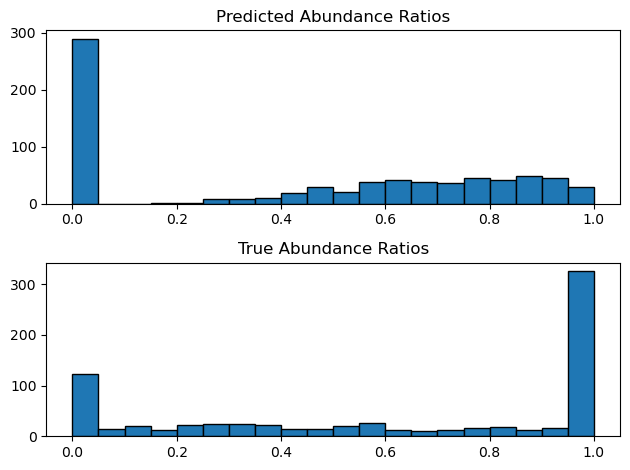

In [180]:
# Comparing the distribution of abundance ratios in the 0-1 range...
fig, ax = plt.subplots(2)

pred_ratios_0_1 = pred_ratios[pred_ratios <= 1]
ax[0].hist(pred_ratios_0_1, edgecolor = 'black', bins = 20)
ax[0].set_title('Predicted Abundance Ratios')

true_ratios_0_1 = test_ratios[test_ratios <= 1]
ax[1].hist(true_ratios_0_1, edgecolor = 'black', bins = 20)
ax[1].set_title('True Abundance Ratios')

fig.tight_layout()

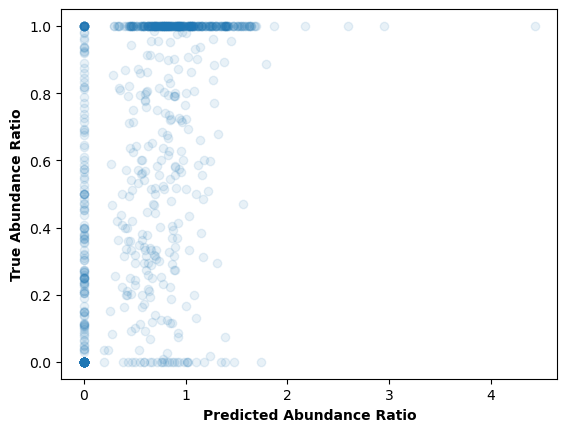

In [181]:
# Regression results, abundance ratio
threshold_mask = test_ratios <= 1

plt.scatter(pred_ratios[threshold_mask], test_ratios[threshold_mask], alpha = 0.1)

plt.xlabel('Predicted Abundance Ratio', weight = 'bold')
plt.ylabel('True Abundance Ratio', weight = 'bold');

# ML-based hurdle models

Might as well do a cross-validated search for the best model for each component of the hurdle model.